### Import modules

In [2]:
from skimage.color import rgb2hed, hed2rgb
import matplotlib.pyplot as plt
import numpy as np

import h5py
import sklearn
from sklearn import manifold
from sklearn.utils import shuffle

In [3]:
with h5py.File('../../pcam/training_split.h5', 'r') as f:
  train_data = f['x'][:]

with h5py.File('../../pcam/validation_split.h5', 'r') as f:
  val_data = f['x'][:]

with h5py.File('../../pcam/test_split.h5', 'r') as f:
  test_data = f['x'][:]

In [4]:
with h5py.File('../../Labels/Labels/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
    train_labels = f['y'][:].reshape(-1,)

with h5py.File('../../Labels/Labels/camelyonpatch_level_2_split_valid_y.h5', 'r') as f:
    val_labels = f['y'][:].reshape(-1,)

with h5py.File('../../Labels/Labels/camelyonpatch_level_2_split_test_y.h5', 'r') as f:
    test_labels = f['y'][:].reshape(-1,)

In [7]:
n_samples = 1000

## Distribution of labels

In [8]:
train_data, train_labels = shuffle(train_data, train_labels, n_samples=n_samples, random_state=0)

In [9]:
positive_samples = train_data[train_labels == 1]
negative_samples = train_data[train_labels == 0]

### Stain separation

In [10]:
def stain_separation(image):
    """
    Perform stain separation using Hematoxylin-Eosin-DAB (HED) color space.
    """
    # Convert to Hematoxylin-Eosin-DAB (HED) space
    hed = rgb2hed(image)

    # Extract stains
    hematoxylin = hed[:, :, 0]  # Nuclei (Hematoxylin)
    eosin = hed[:, :, 1]        # Cytoplasm (Eosin)
    dab = hed[:, :, 2]          # Optional: DAB (if present)

    # Visualize the stains
    fig, axes = plt.subplots(1, 4, figsize=(16, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[1].imshow(-hematoxylin, cmap='gray')
    axes[1].set_title("Hematoxylin (Nuclei)")
    axes[2].imshow(-eosin, cmap='gray')
    axes[2].set_title("Eosin (Cytoplasm)")
    axes[3].imshow(-dab, cmap='gray')
    axes[3].set_title("DAB (Optional)")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return hematoxylin, eosin, dab

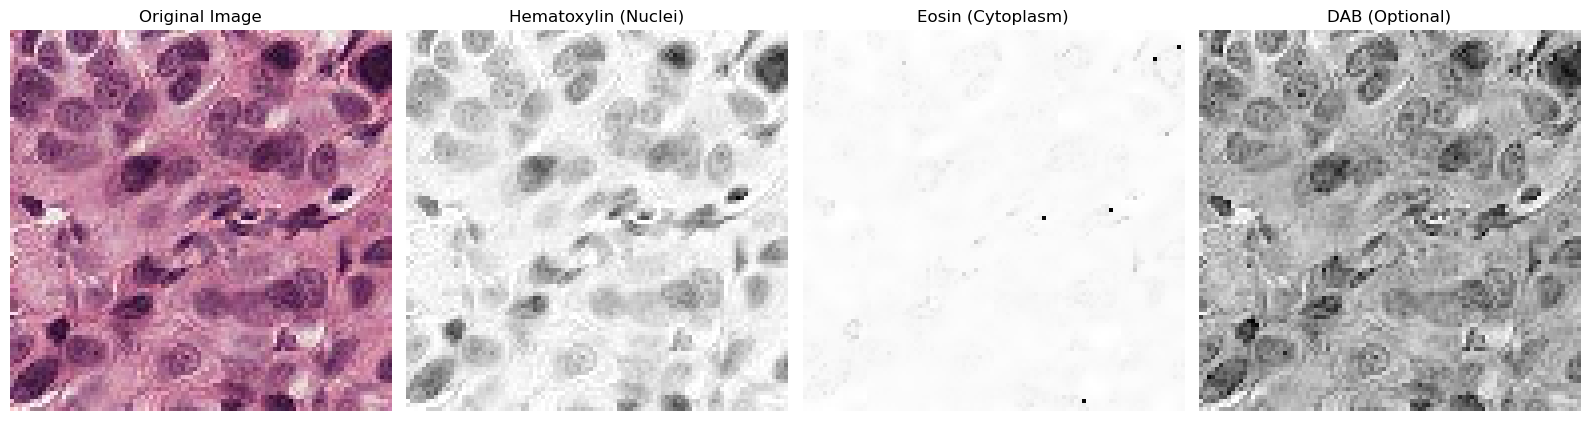

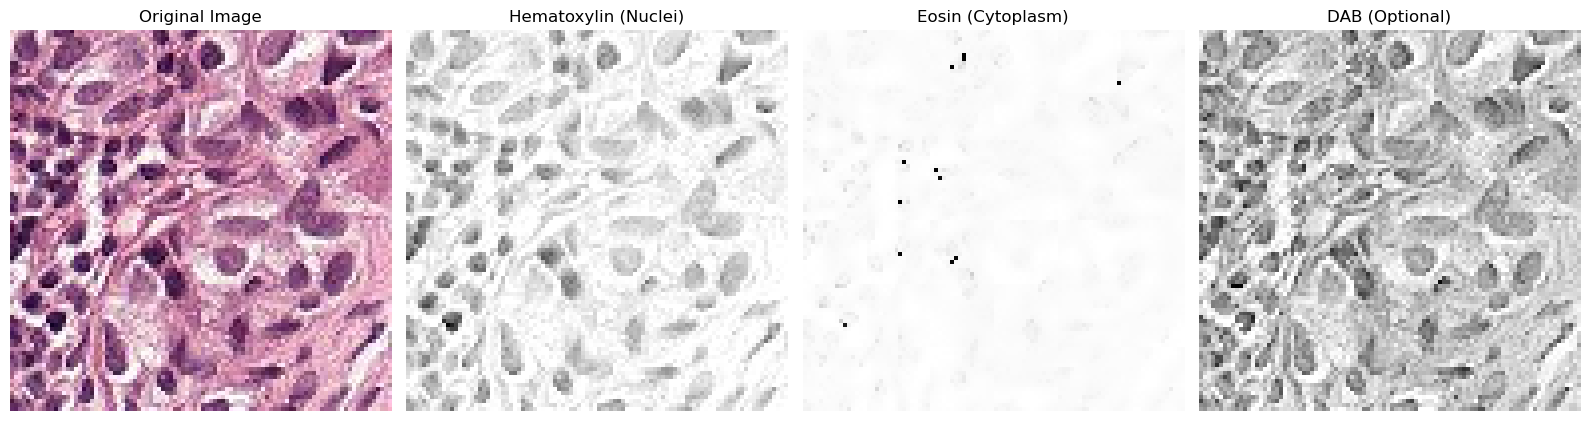

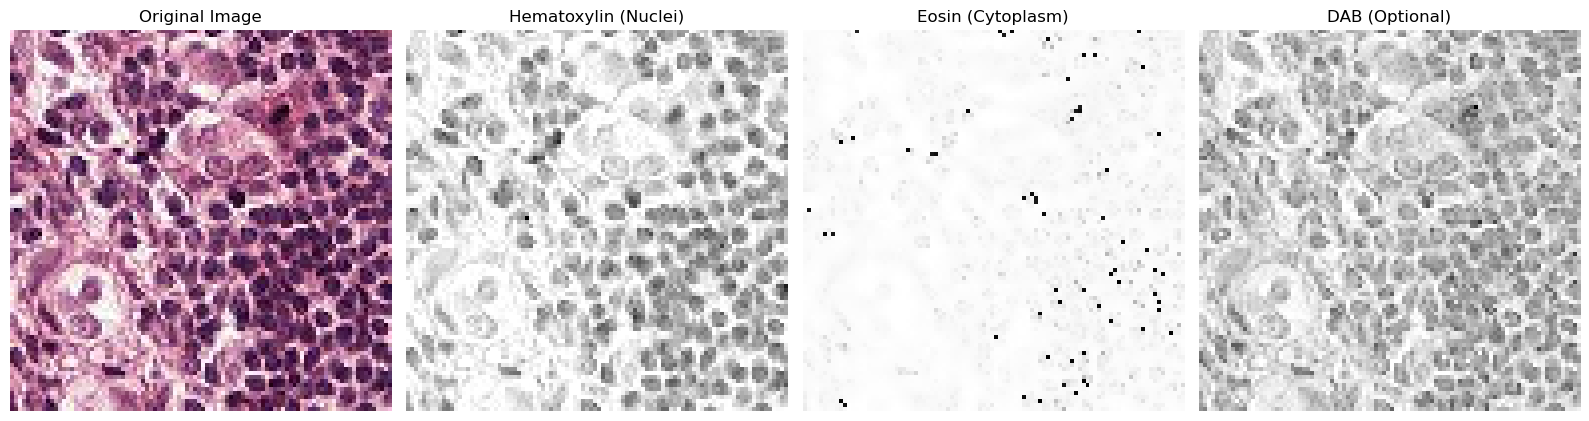

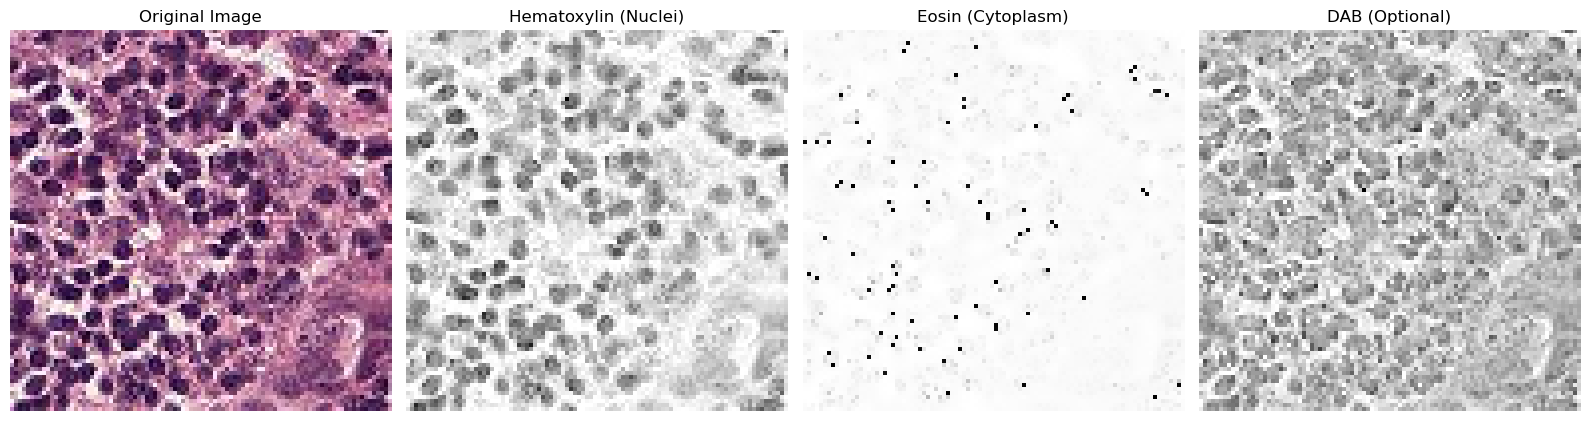

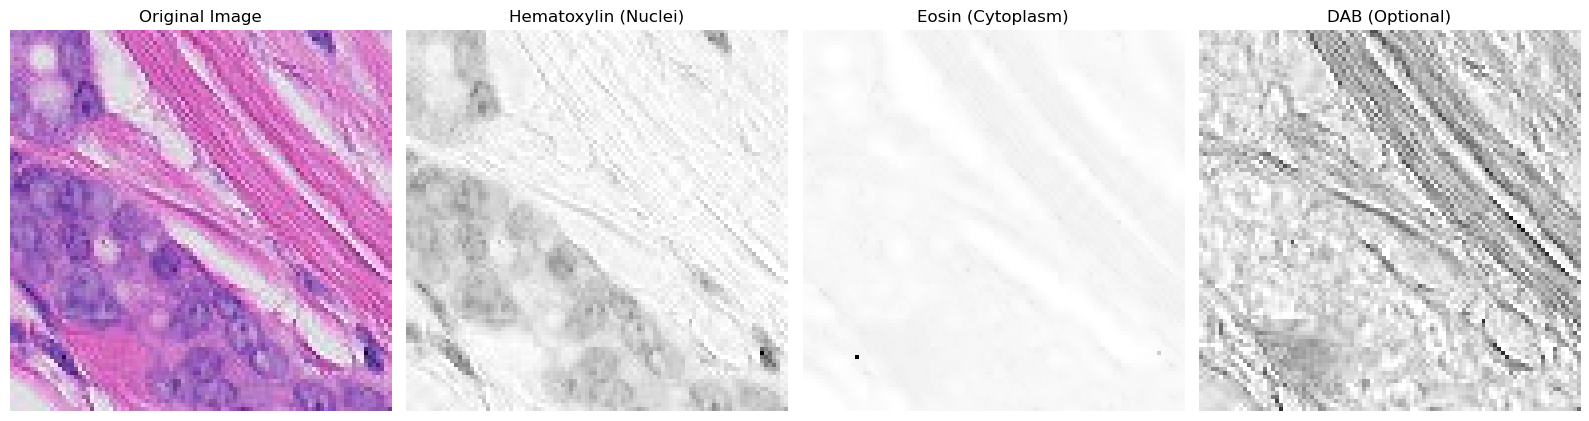

In [8]:
# Positive samples

for i in range(5):
    example_image = positive_samples[np.random.choice(100)]
    hematoxylin_channel, eosin_channel, dab_channel = stain_separation(example_image)

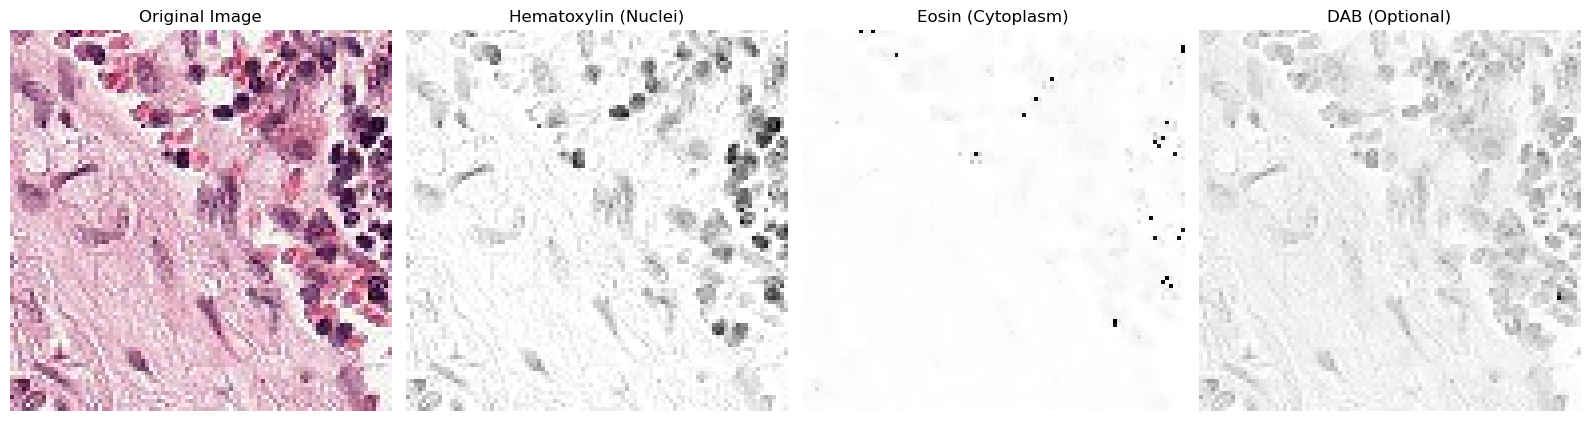

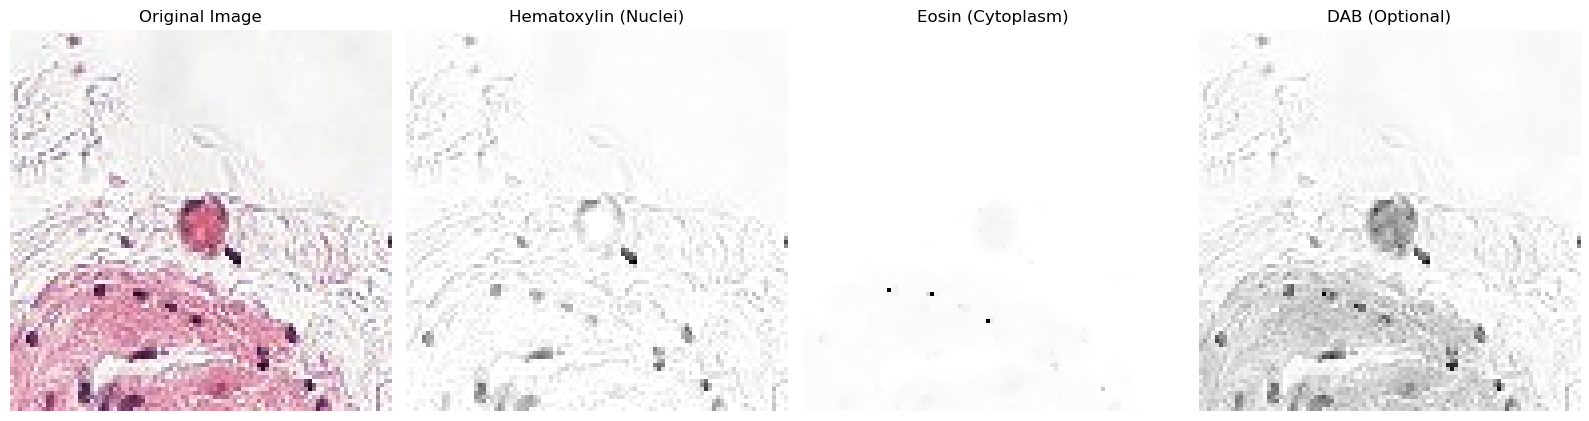

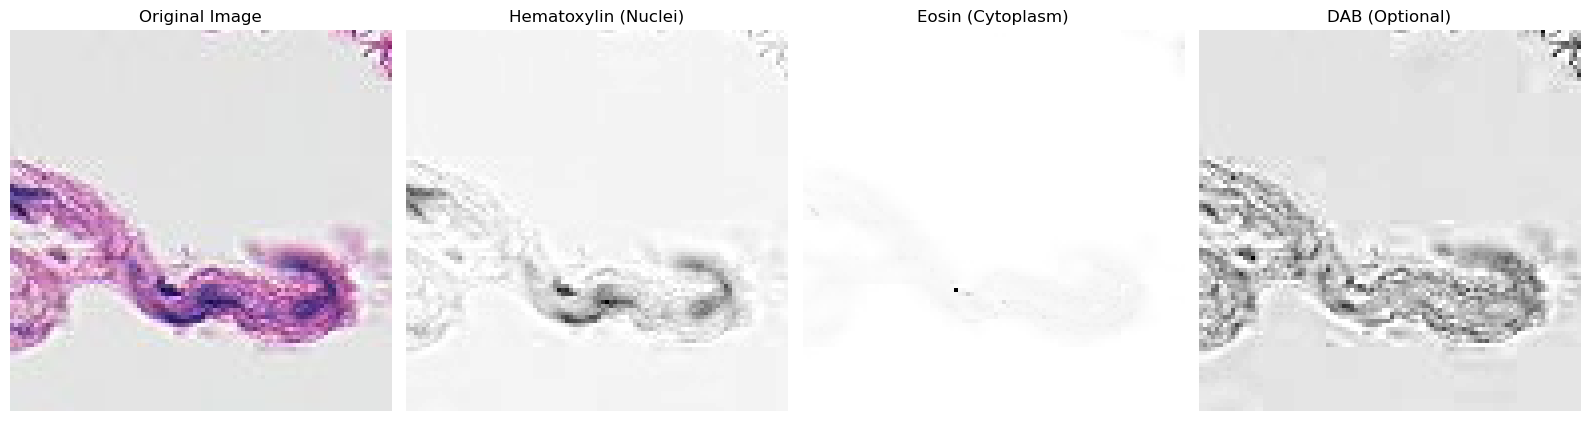

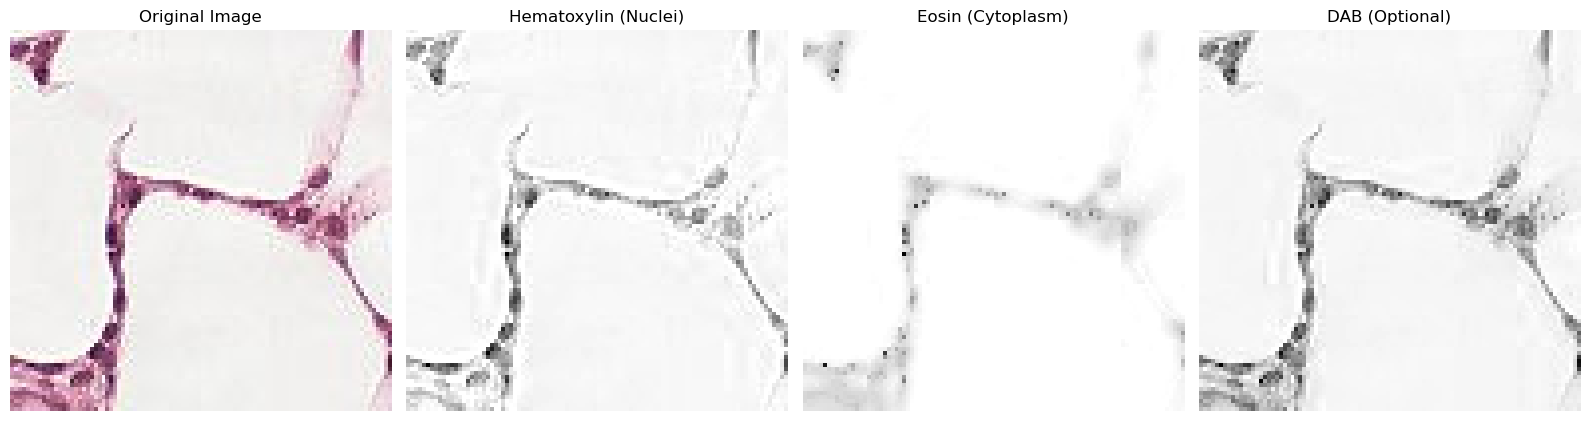

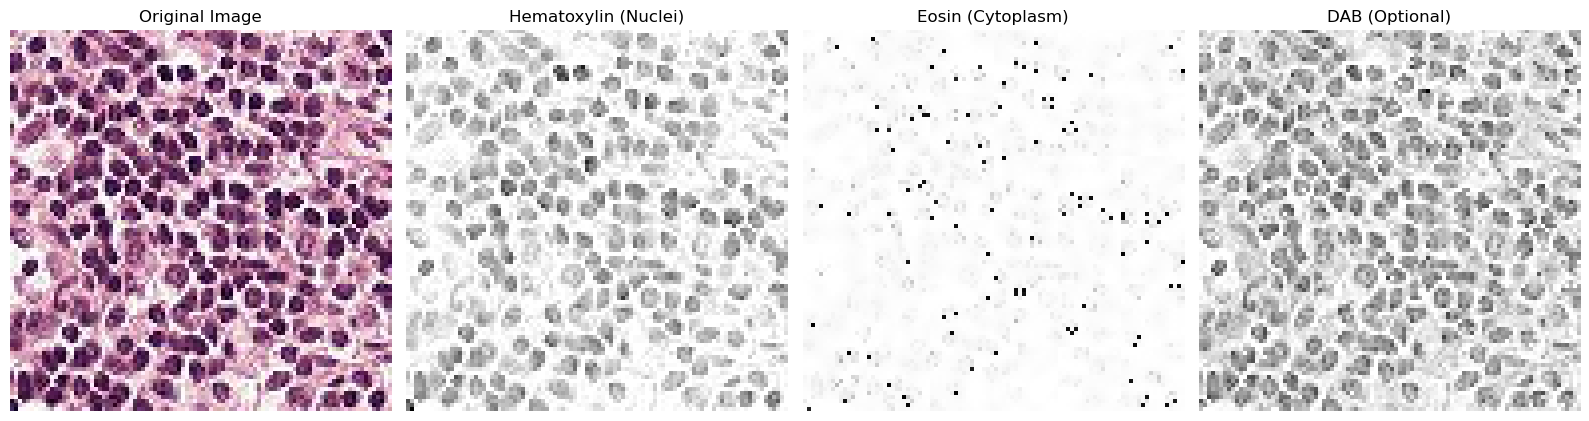

In [9]:
# Negative samples

for i in range(5):
    example_image = negative_samples[np.random.choice(100)]
    hematoxylin_channel, eosin_channel, dab_channel = stain_separation(example_image)

### Artifact removal

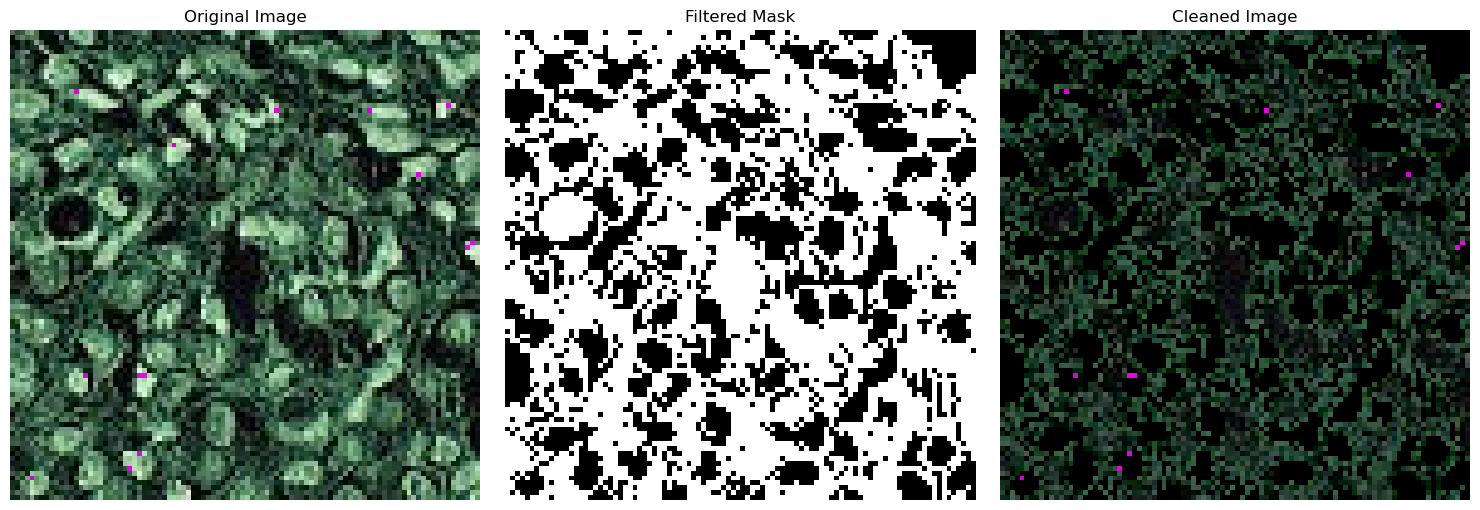

In [15]:
from skimage import measure, filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np


def remove_artifacts(image, min_area=100):
    """
    Advanced artifact removal using shape and intensity features.
    """
    # Step 1: Convert to grayscale
    gray_image = rgb2gray(image)
    
    # Step 2: Adaptive thresholding
    thresh = filters.threshold_otsu(gray_image)
    binary_mask = gray_image < thresh
    
    # Step 3: Label connected components
    labeled_image = measure.label(binary_mask)
    regions = measure.regionprops(labeled_image, intensity_image=gray_image)
    
    # Step 4: Filter based on features (size, intensity, shape, etc.)
    filtered_mask = np.zeros_like(binary_mask)
    for region in regions:
        if region.area > min_area and region.eccentricity < 0.8:  # Example criteria
            filtered_mask[labeled_image == region.label] = 1
    
    # Step 5: Apply mask to the image
    clean_image = image.copy()
    clean_image[~filtered_mask] = 0  # Set artifacts to black
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[1].imshow(filtered_mask, cmap='gray')
    axes[1].set_title("Filtered Mask")
    axes[2].imshow(clean_image)
    axes[2].set_title("Cleaned Image")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return clean_image

# Example Usage
example_image = (positive_samples[0] * 255).astype(np.uint8)  # Convert to 0-255 scale
cleaned_image = remove_artifacts(example_image)


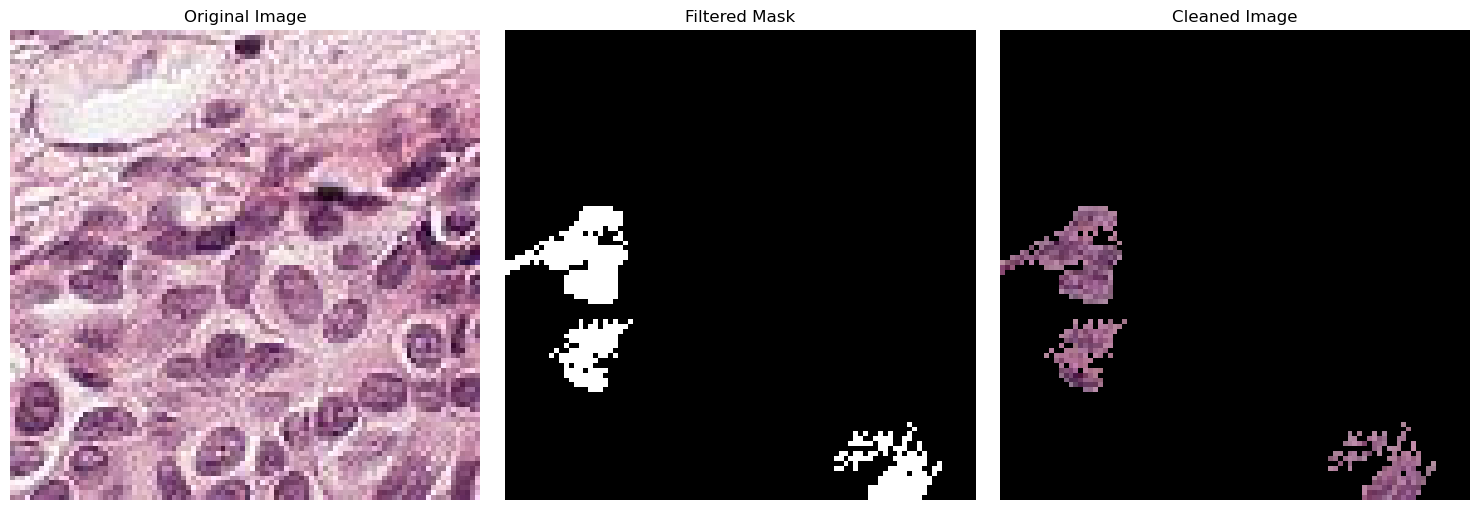

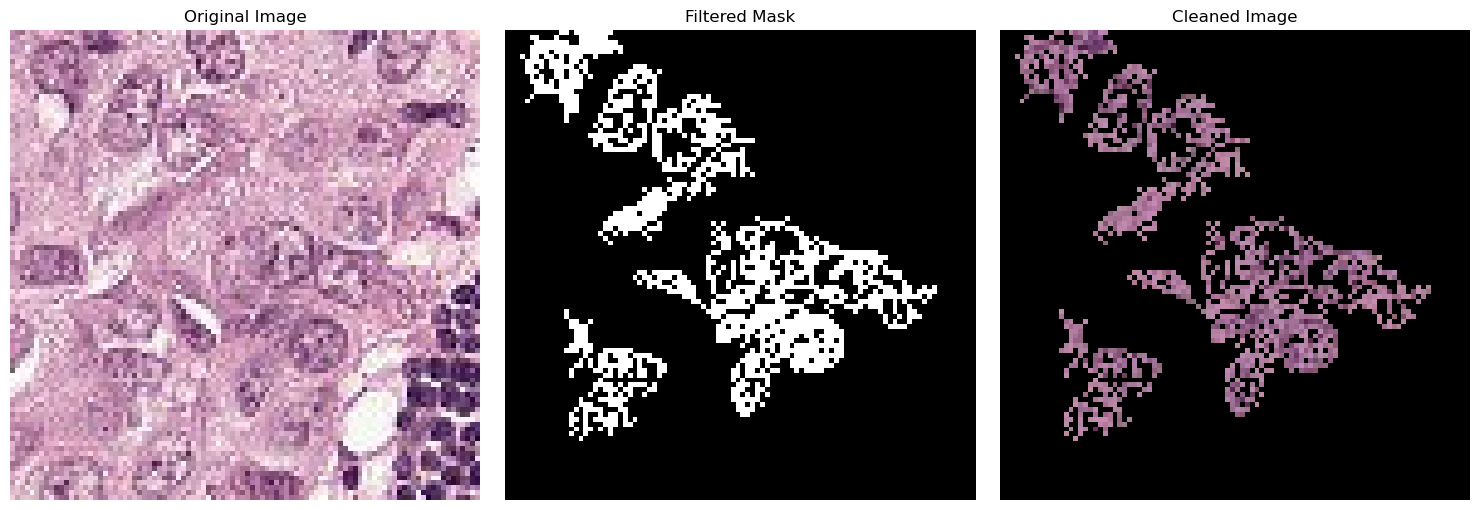

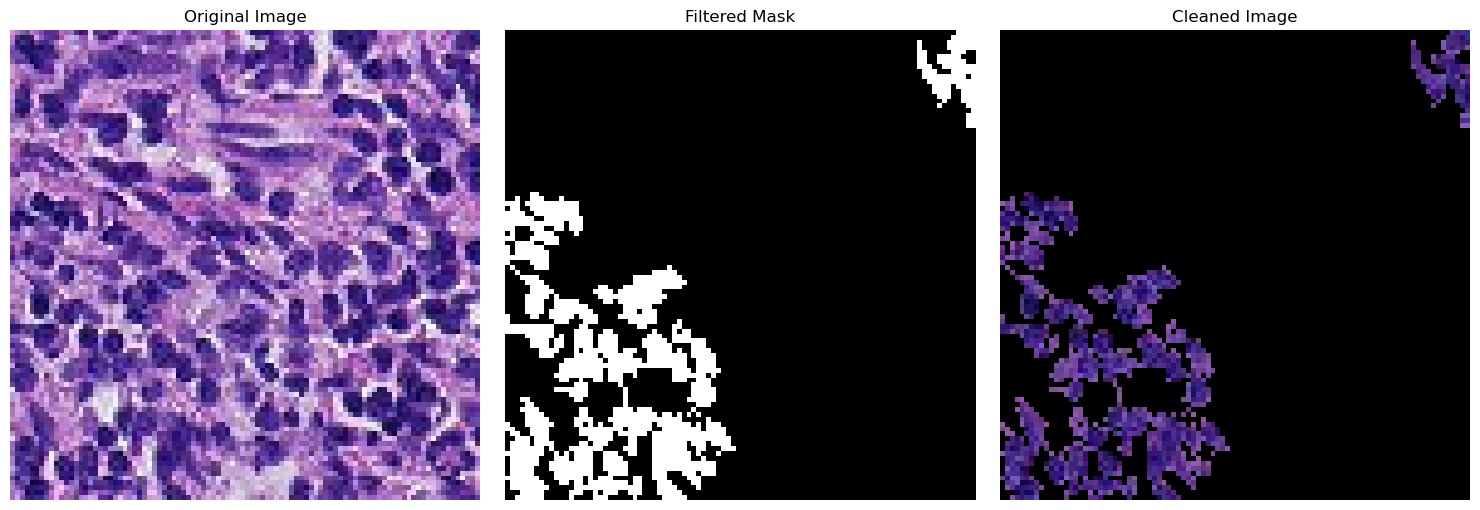

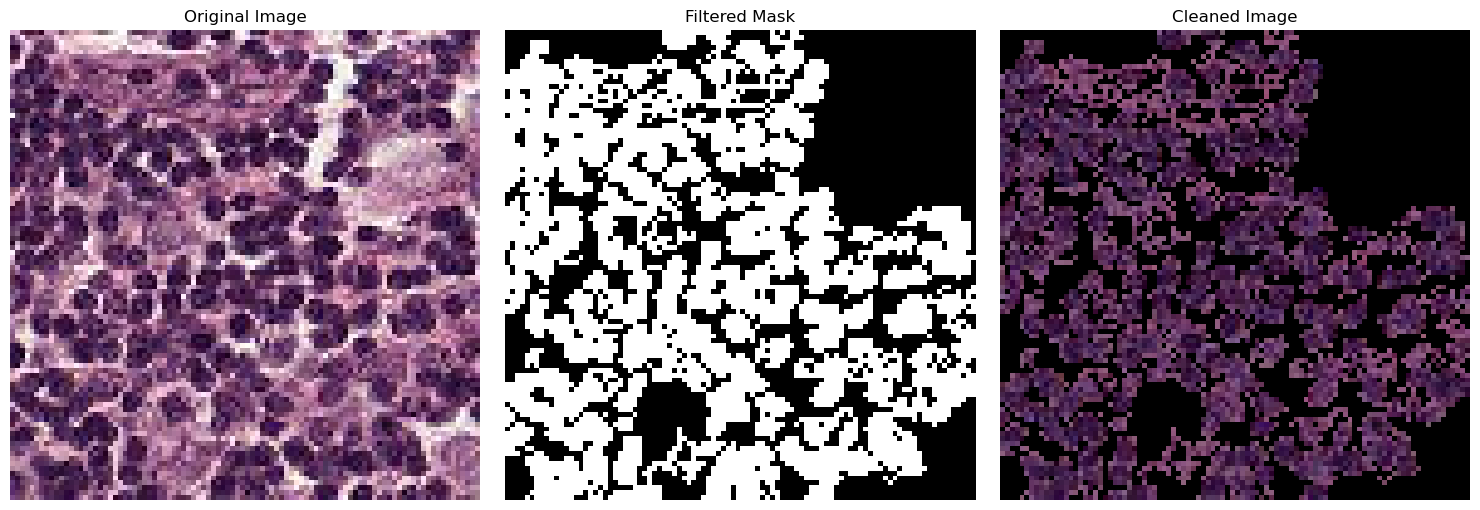

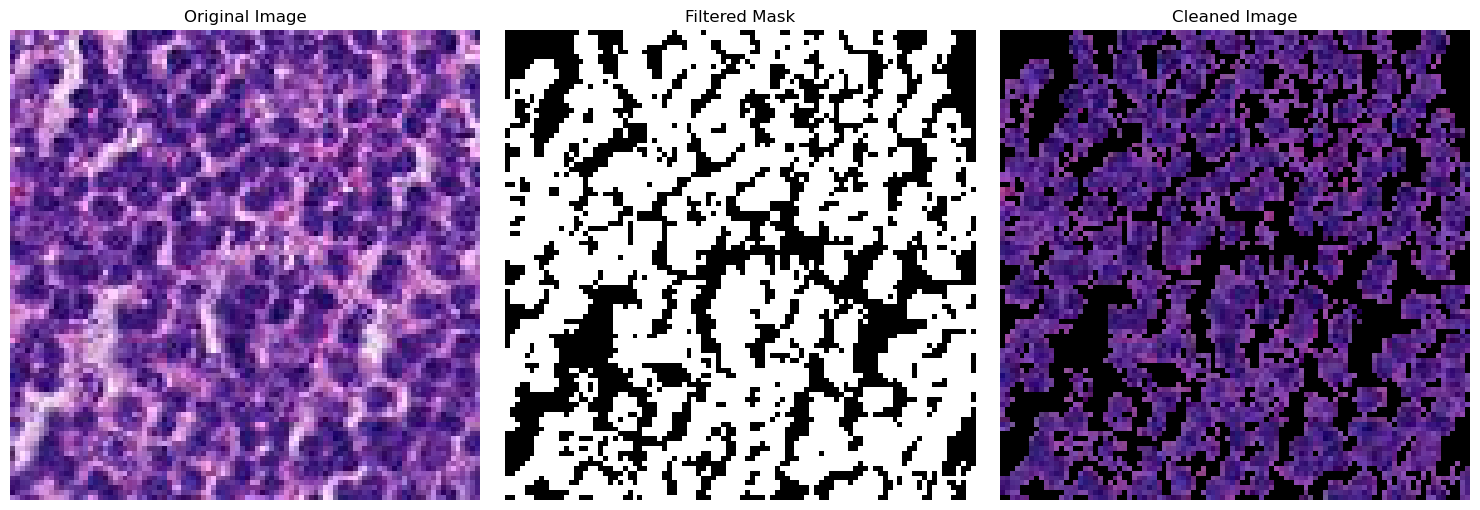

In [16]:
# Positive samples

for i in range(5):
    example_image = positive_samples[np.random.choice(100)]
    cleaned_image_ml = remove_artifacts(example_image)

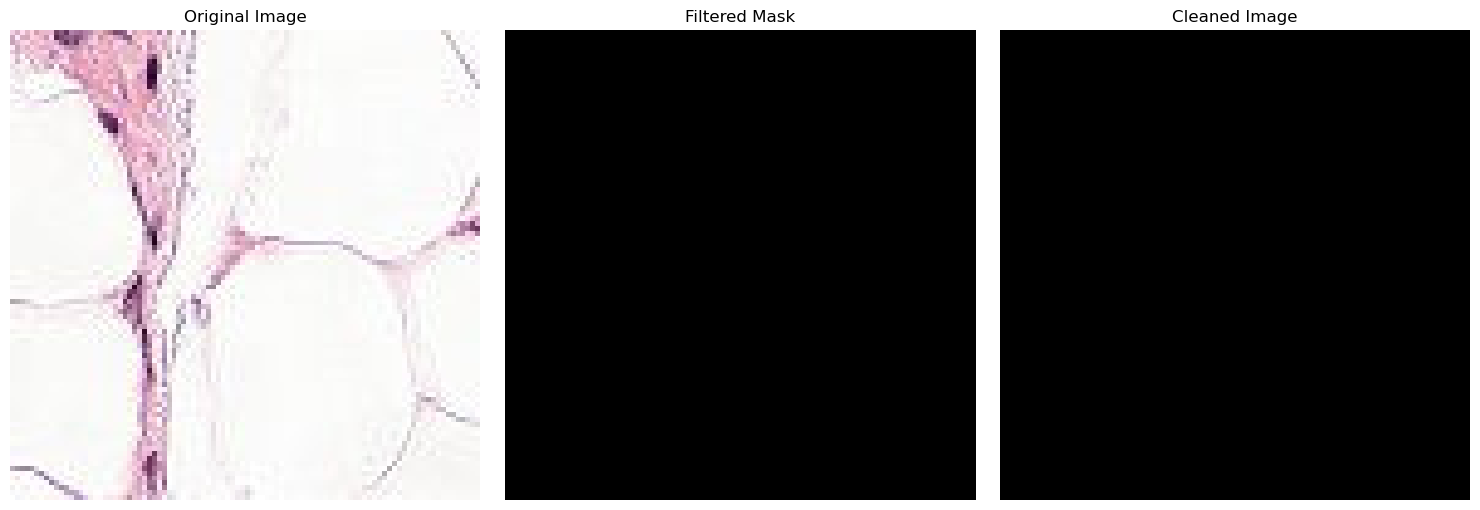

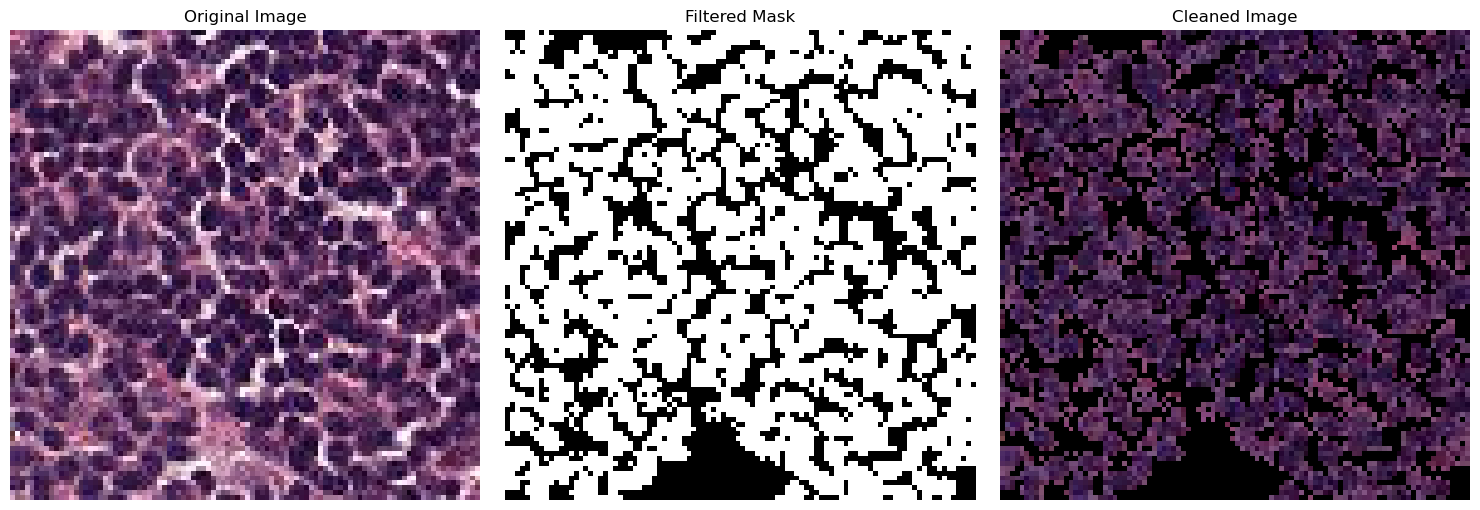

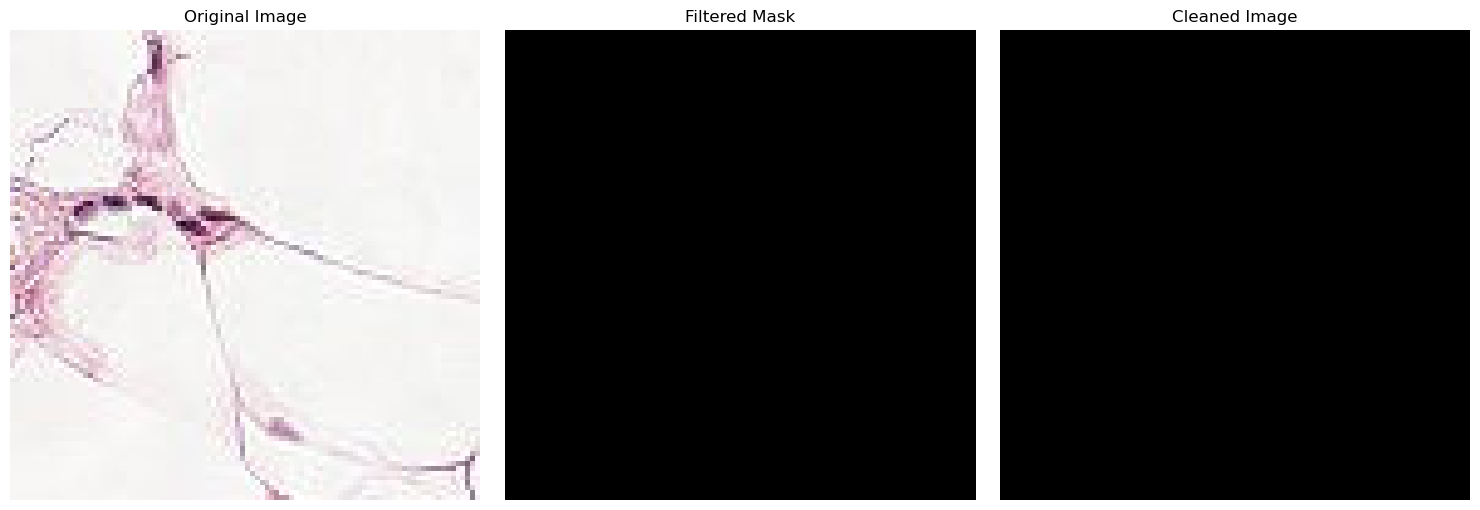

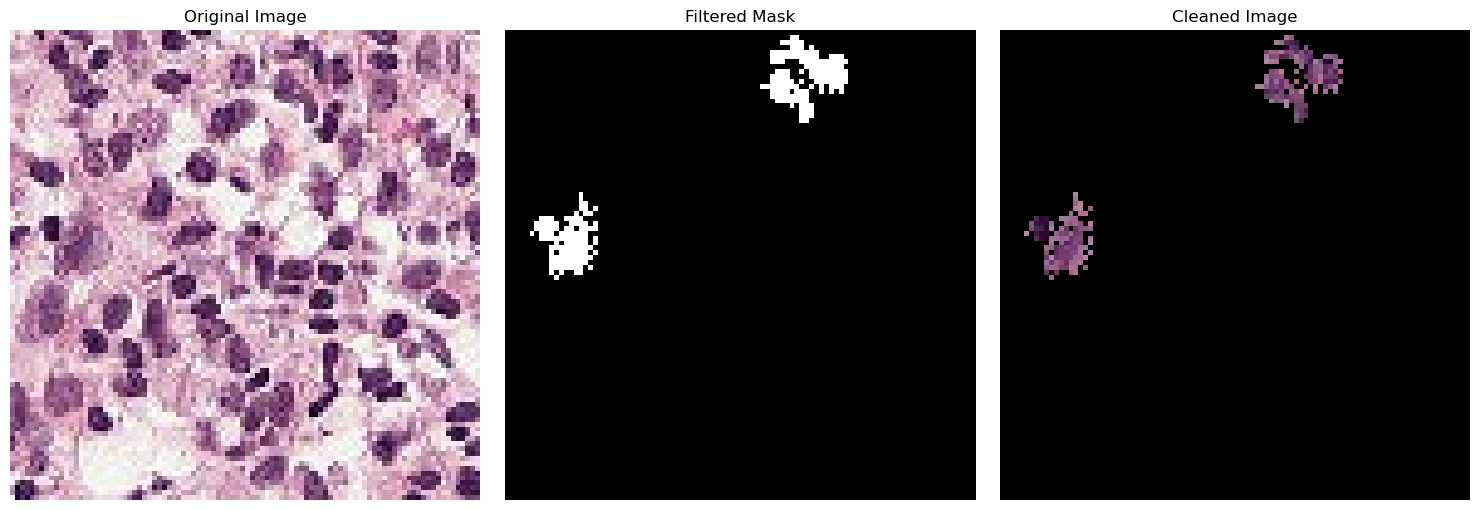

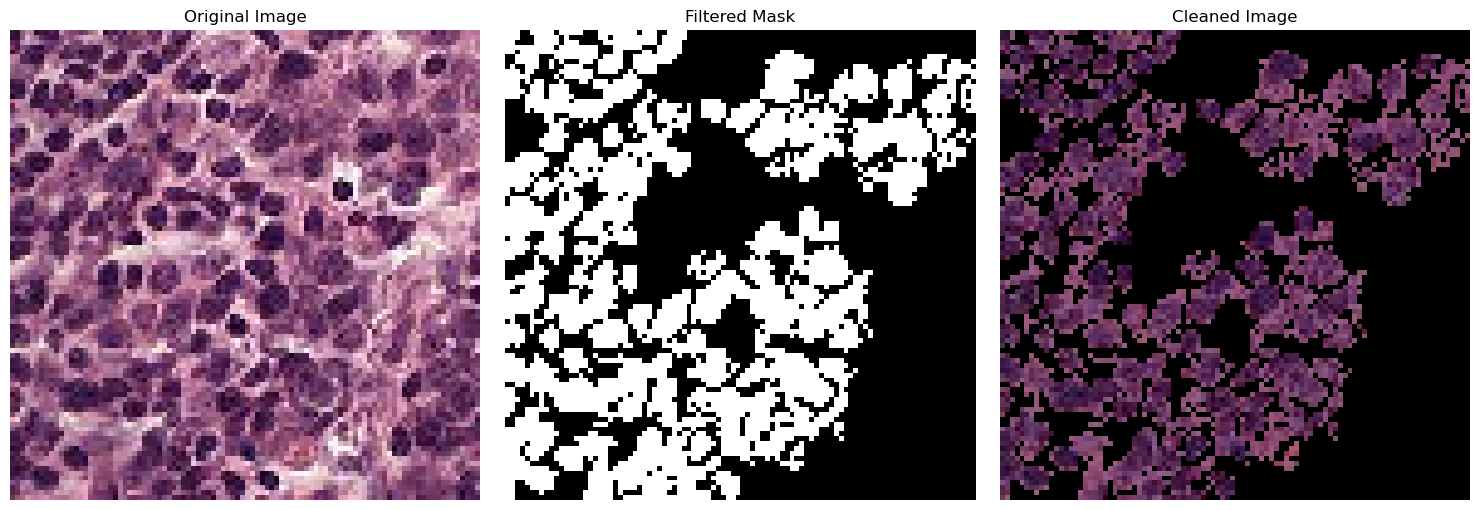

In [17]:
# Negative samples

for i in range(5):
    example_image = negative_samples[np.random.choice(100)]
    cleaned_image_ml = remove_artifacts(example_image)

### Wavelet transform

In [11]:
import pywt

def compress_image_grayscale(image_array, wavelet='haar', threshold=20):
    """
    Compress a color image by converting it to grayscale and applying wavelet compression.
    
    Parameters:
    - image_array: Input RGB image array (96, 96, 3).
    - wavelet: Type of wavelet ('haar', 'db1', etc.).
    - threshold: Threshold for coefficient shrinking.
    
    Returns:
    - compressed_image: Reconstructed grayscale image after compression.
    """
    # Step 1: Convert to grayscale
    grayscale_image = np.dot(image_array[..., :3], [0.299, 0.587, 0.114])
    
    # Step 2: Perform 2D wavelet decomposition
    coeffs = pywt.wavedec2(grayscale_image, wavelet=wavelet, level=2)
    cA, details = coeffs[0], coeffs[1:]
    
    # Step 3: Apply thresholding to detail coefficients
    def threshold_coeffs(coeffs, threshold):
        return [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    
    details_thresh = [threshold_coeffs(detail, threshold) for detail in details]
    coeffs_thresh = [cA] + details_thresh
    
    # Step 4: Reconstruct the image
    compressed_image = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)  # Ensure valid pixel range
    print(compressed_image.shape)
    
    # Step 5: Visualize results
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title("Original Grayscale Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(compressed_image, cmap='gray')
    plt.title("Compressed Grayscale Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return compressed_image

(96, 96)


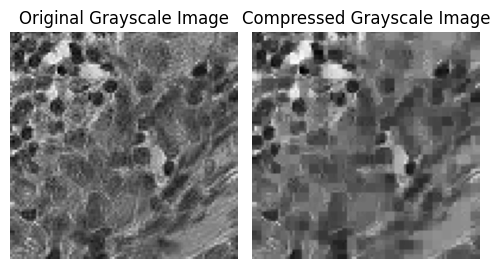

(96, 96)


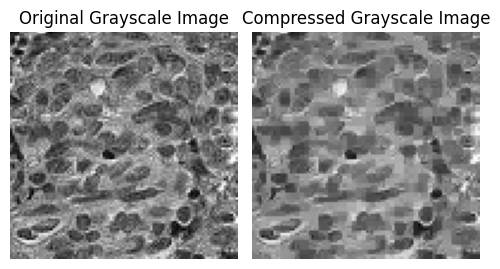

(96, 96)


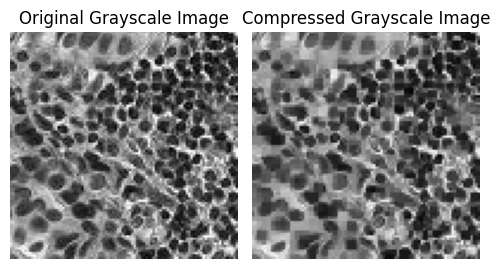

(96, 96)


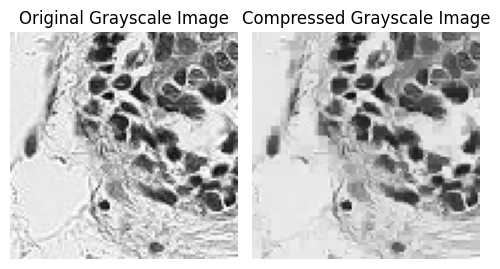

(96, 96)


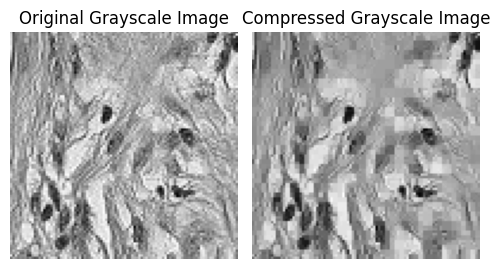

In [12]:
# Positive samples

for i in range(5):
    example_image = positive_samples[np.random.choice(100)]
    cleaned_image_ml = compress_image_grayscale(example_image)

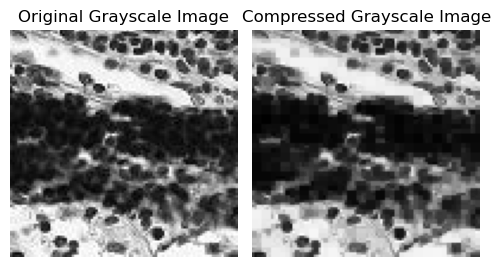

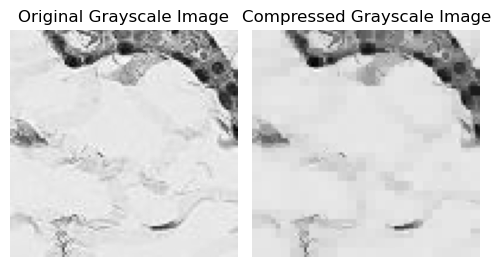

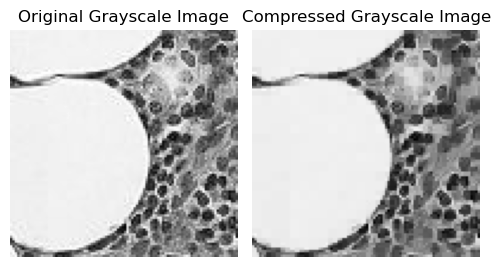

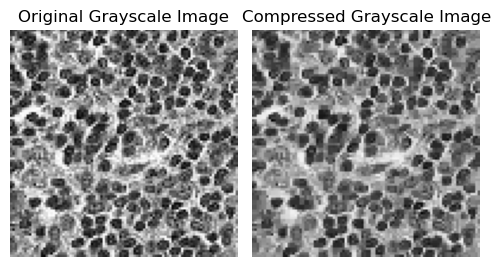

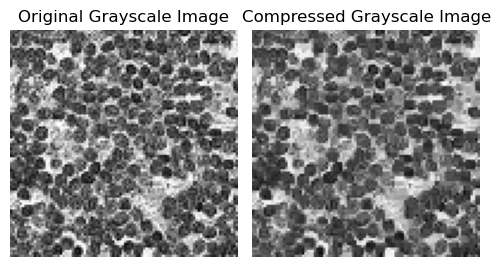

In [26]:
# Negative samples

for i in range(5):
    example_image = negative_samples[np.random.choice(100)]
    cleaned_image_ml = compress_image_grayscale(example_image)